### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import odc.geo.xr
from datacube.utils.cog import write_cog
import netCDF4
import h5py
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
from dea_tools.plotting import xr_animation
import shapely
from dea_tools.spatial import xr_vectorize
import cmocean
import re

### boxes

In [2]:
boxes_vec = gpd.read_file('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes.geojson')

In [3]:
boxes = xr.open_dataset('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes.nc')

In [4]:
boxes_25 = xr.open_dataset('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes_25km.nc')

### Ice motion

In [5]:
ds = xr.open_dataset('/g/data/gv90/P6_data/NSIDC/NSIDC-0116/icemotion_weekly_sh_25km_20190101_20191231_v4.1.nc')

In [6]:
ds = ds.sel(time=slice("2019-06-01", "2019-08-31")).groupby('time.month').mean(dim='time')

In [7]:
ds = ds.rename({'u':'u-','v':'v-'})

In [8]:
ds = ds.mean(dim='month')

In [9]:
crop = ds.where((ds.x > -3000000) & (ds.x < 0) & (ds.y > 500000) & (ds.y < 3000000), drop=True)
crop = crop.coarsen({'x':5}, boundary='trim').mean().coarsen({'y':5}, boundary='trim').mean()

### 3 month mean MYI - 2019

In [10]:
# 3 month mean - 2019 - ice types uncorrected
icetype = xr.open_dataset('/g/data/gv90/sc0554/2019_junjulaug_mean_IceTypesUncorrected.nc')
# icetype = icetype.where((icetype['YI'] > 15) | (icetype['FYI'] > 15) | (icetype['MYI'] > 15) | (icetype['TOTAL_ICE'] > 15))
icetype_crop=icetype.where((icetype.Y > -3000000) & (icetype.Y < 0) & (icetype.X > 500000) & (icetype.X < 3000000), drop=True)
icetype_crop = icetype_crop.drop('spatial_ref')
YI_FYI = icetype_crop['YI'] + icetype_crop['FYI']

# multiple icetype subplots

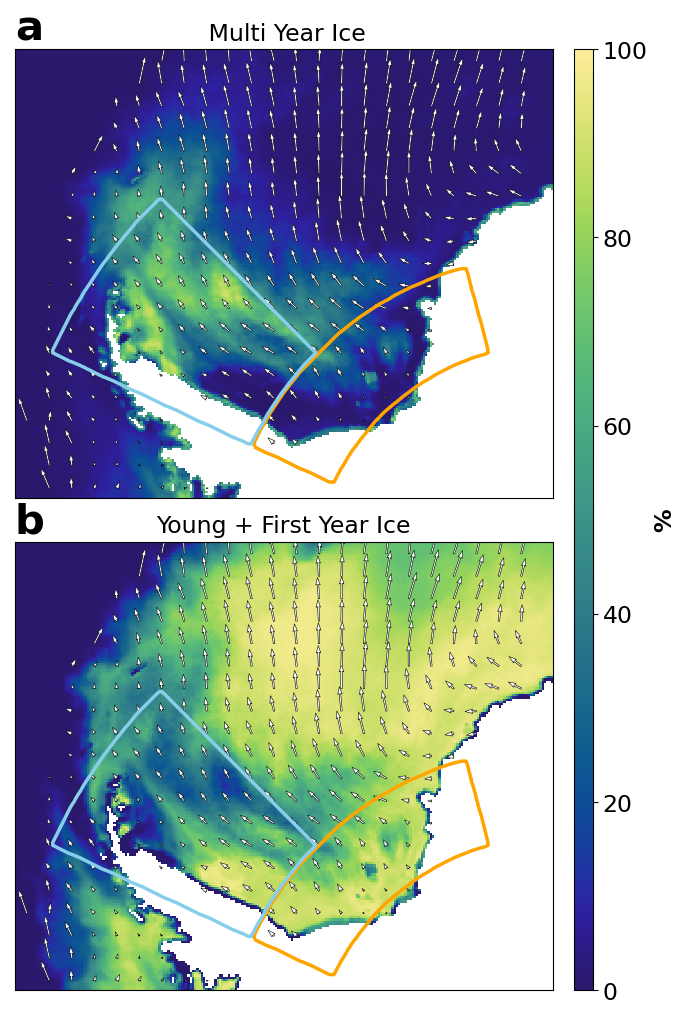

In [45]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15,10))
cmap = cmocean.cm.haline
box_colours = ['orange','skyblue']
plt.tight_layout()  
fig.tight_layout()

[axi.xaxis.set_visible(False) for axi in ax.ravel()]
[axi.yaxis.set_visible(False) for axi in ax.ravel()]

icetype_crop['MYI'].plot(cmap=cmap, ax=ax[0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0], linewidth=2.5)
quiver = ax[0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[0].set_title('a', fontsize=30, loc='left', weight='bold')
ax[0].set_title(' Multi Year Ice', fontsize=17, loc='center')

YI_FYI = icetype_crop['YI'] + icetype_crop['FYI']
a = YI_FYI.plot(cmap=cmap, ax=ax[1], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1], linewidth=2.5)
quiver = ax[1].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[1].set_title('b', fontsize=30, loc='left', weight='bold')
ax[1].set_title('Young + First Year Ice', fontsize=17, loc='center')

cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=50, pad=0.015)
# cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025,orientation='horizontal', extend='max')
cbar.set_label(label="%", size=17,weight='bold')
cbar.ax.tick_params(labelsize=17)

plt.savefig('/g/data/jk72/sc0554/icemotion.png', dpi=300, bbox_inches='tight')
# plt.show()

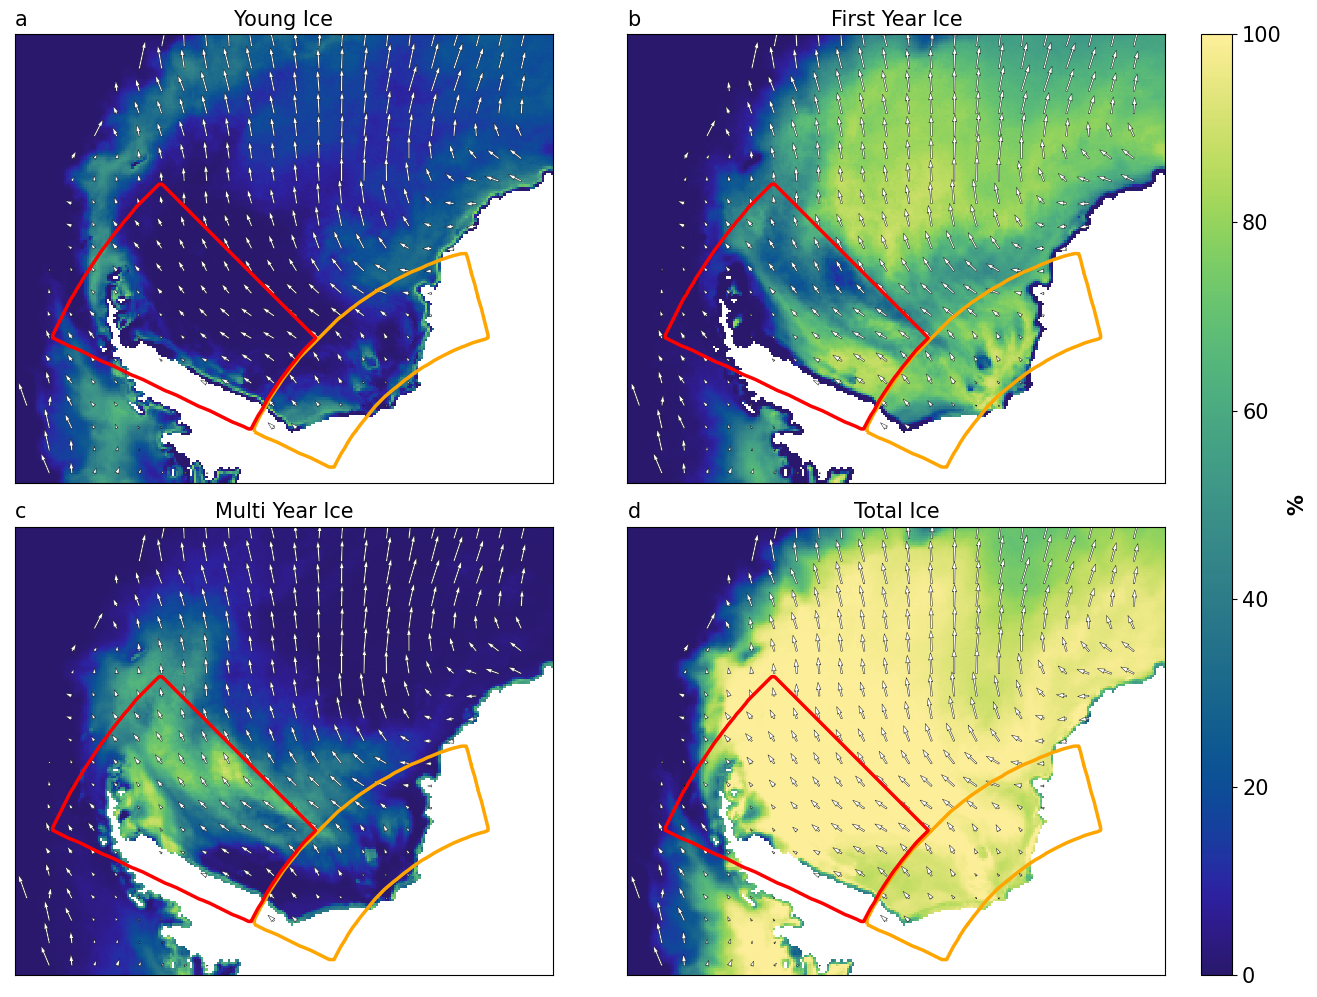

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
cmap = cmocean.cm.haline
box_colours = ['orange','r']
plt.tight_layout()  
fig.tight_layout()

[axi.xaxis.set_visible(False) for axi in ax.ravel()]
[axi.yaxis.set_visible(False) for axi in ax.ravel()]

a = icetype_crop['YI'].plot(cmap=cmap, ax=ax[0, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0,0], linewidth=2.5)
quiver = ax[0,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[0,0].set_title('a', fontsize=15, loc='left')
ax[0,0].set_title('Young Ice', fontsize=15, loc='center')


icetype_crop['FYI'].plot(cmap=cmap, ax=ax[0, 1], vmin=0, vmax=100, add_colorbar=False,)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0,1], linewidth=2.5)
quiver = ax[0,1].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[0,1].set_title('b', fontsize=15, loc='left')
ax[0,1].set_title('First Year Ice', fontsize=15, loc='center')


icetype_crop['MYI'].plot(cmap=cmap, ax=ax[1, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1,0], linewidth=2.5)
quiver = ax[1,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[1,0].set_title('c', fontsize=15, loc='left')
ax[1,0].set_title('Multi Year Ice', fontsize=15, loc='center')

icetype_crop['TOTAL_ICE'].plot(cmap=cmap, ax=ax[1, 1], vmin=0, vmax=100,add_colorbar=False)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1,1], linewidth=2.5)
quiver = ax[1,1].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[1,1].set_title('d', fontsize=15, loc='left')
ax[1,1].set_title('Total Ice', fontsize=15, loc='center')                  

cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025)
# cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025,orientation='horizontal', extend='max')
cbar.set_label(label="%", size=15,weight='bold')
cbar.ax.tick_params(labelsize=15)

# plt.savefig('/g/data/jk72/sc0554/icemotion.png', dpi=300, bbox_inches='tight')
plt.show()

### Timeseries analysis and plotting

In [12]:
# Load Daily Ice type data
ds = xr.open_dataset('/g/data/gv90/sc0554/2018_2022_IceTypesUncorrected.nc', chunks='auto')
ds = ds.rename_dims({'X':'x','Y':'y'})
ds = ds.rename({'X':'x', 'Y':'y'})

# Resample to weekly
resampled = ds.resample(time='W').mean()
resampled = resampled.drop('spatial_ref')

In [13]:
# Load Monthly IS2 data
ATL20 = xr.open_dataset('/g/data/jk72/sc0554/ATL20_new.nc', chunks='auto')

# swap dimensions of ATL20 to match boxes
ATL20 = ATL20.rename_dims({'grid_x':'y','grid_y':'x'})
ATL20 = ATL20.rename({'grid_x':'y', 'grid_y':'x'})

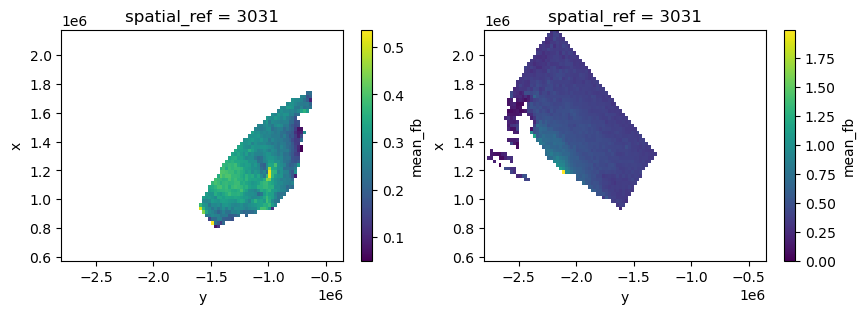

In [14]:
# Calculate spatial mean fb for each box
ATL20_masked_SWSbox = ATL20['mean_fb'].where(boxes_25['SWSbox'] == True).mean(dim=['x','y'])
ATL20_masked_WWSnocbox = ATL20['mean_fb'].where(boxes_25['WWSnocbox'] == True).mean(dim=['x','y'])

# plot to check correct boxes being made

fig, axs = plt.subplots(ncols=2, figsize=(10,3))

ATL20['mean_fb'].where(boxes_25['SWSbox'] == True).mean(dim='time').plot(ax=axs[0])
ATL20['mean_fb'].where(boxes_25['WWSnocbox'] == True).mean(dim='time').plot(ax=axs[1])

In [15]:
# Convert ATL20 data to pandas
ATL20_masked_SWSbox_df = ATL20_masked_SWSbox.to_pandas().rename('Freeboard').round(2)
ATL20_masked_WWSnocbox_df = ATL20_masked_WWSnocbox.to_pandas().rename('Freeboard').round(2)

In [16]:
# Subset the ice type dataset before masking with boxes otherwise it's computationally very slow

minx = min(boxes.x)
maxx = max(boxes.x)
miny = min(boxes.y)
maxy = max(boxes.y)

subset = resampled.sel(
    y=((resampled.y >= miny) & (resampled.y <= maxy)),
    x=((resampled.x >= miny) & (resampled.x <= maxx))
)

masked_SWSbox = subset.where(boxes['SWSbox'] == True).mean(dim=['x','y'])
masked_WWSnocbox = subset.where(boxes['WWSnocbox'] == True).mean(dim=['x','y'])

In [17]:
cols = ['MYI', 'FYI', 'YI', 'OW']
masked_SWSbox_df = masked_SWSbox.to_pandas()
masked_WWSnocbox_df = masked_WWSnocbox.to_pandas()
masked_SWSbox_df = masked_SWSbox_df.interpolate(method='linear')
masked_WWSnocbox_df = masked_WWSnocbox_df.interpolate(method='linear')
masked_SWSbox_df['OW'] = 100-masked_SWSbox_df['TOTAL_ICE']
masked_WWSnocbox_df['OW'] = 100-masked_WWSnocbox_df['TOTAL_ICE']

In [18]:
colormap = {'MYI':'green', 'FYI':'gold', 'YI':'lightblue', 'OW':'blue'}

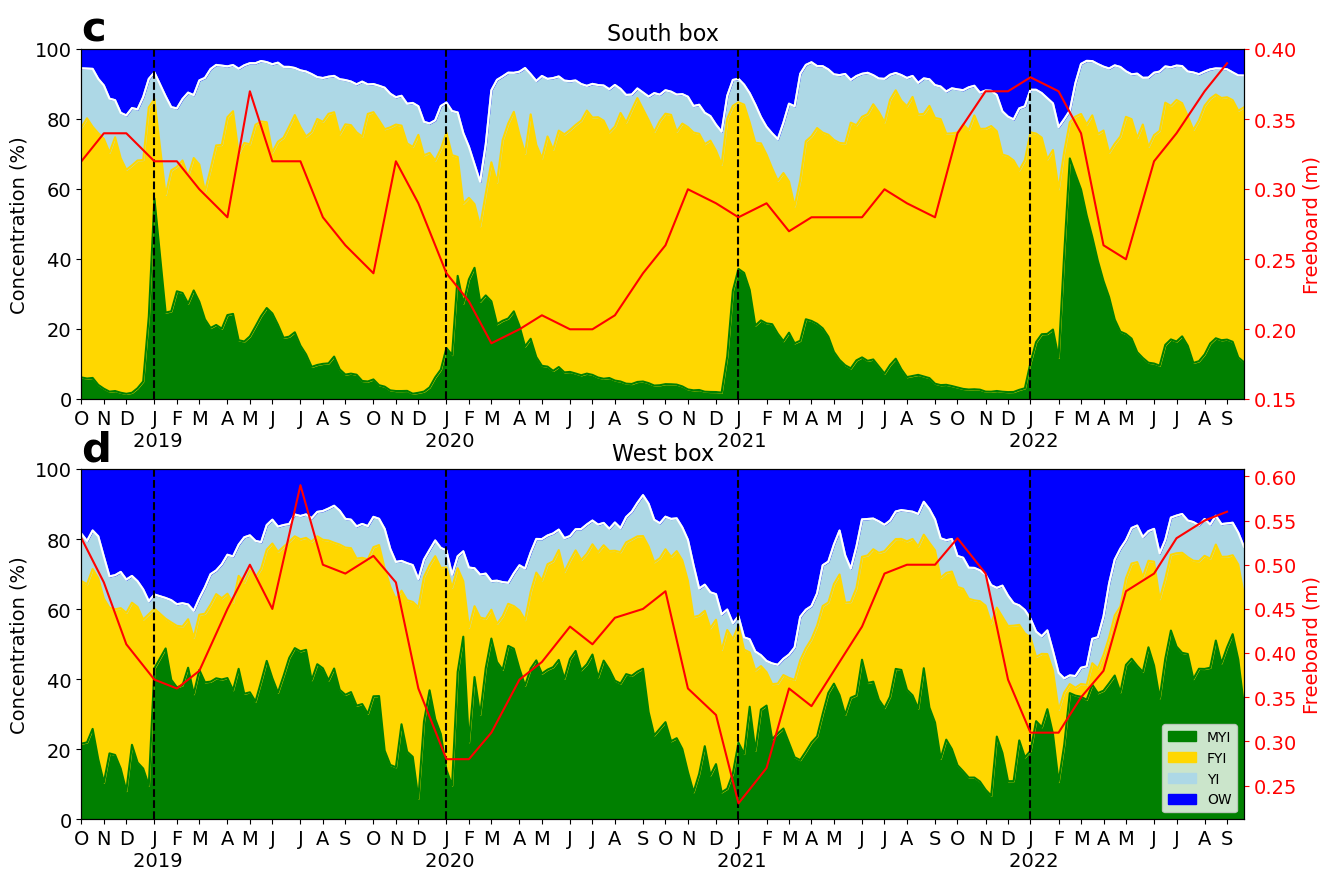

In [47]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15,10))
# plt.tight_layout(rect=[0, 0, .8, 0.8])

custom_labels = [
    t.strftime('%b')[0] +  t.strftime('\n %Y') if t.month == 1 else t.strftime('%b')[0]
    for t in ATL20_masked_SWSbox_df.index
]

fontsize = 14

masked_SWSbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[0], color=colormap, legend=False)#.legend(loc='center left')
ATL20_masked_SWSbox_df.plot(ax=ax[0], secondary_y=True, color='red')
cumulative_sum_south = masked_SWSbox_df[['MYI', 'FYI', 'YI']]['2018-10-01':'2022-10-01'].sum(axis=1)
# Plot the horizontal dividing line
cumulative_sum_south.plot(ax=ax[0], color='white', linestyle='-')

ax[0].set_xticks(ATL20_masked_SWSbox_df.index)
ax[0].set_xticklabels(custom_labels, rotation=0, size=fontsize)
ax[0].right_ax.set_ylim(0.15,0.4)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].set_ylabel('Concentration (%)', size=fontsize)
ax[0].right_ax.set_ylabel('Freeboard (m)', size=fontsize).set_color('red')
ax[0].right_ax.tick_params(axis='y', colors='red', labelsize=fontsize)
ax[0].set_xlabel('')
ax[0].set_title('c', fontsize=30, loc='left', weight='bold')
ax[0].set_title('South box', fontsize=16, loc='center')

area = masked_WWSnocbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[1], color=colormap, legend=False)#.legend(loc='lower left')
line = ATL20_masked_WWSnocbox_df.plot(ax=ax[1], secondary_y=True, color='red')
cumulative_sum_west = masked_WWSnocbox_df[['MYI', 'FYI', 'YI']]['2018-10-01':'2022-10-01'].sum(axis=1)
# Plot the horizontal dividing line
cumulative_sum_west.plot(ax=ax[1], color='white', linestyle='-', label='')

ax[1].legend()
ax[1].right_ax.set_ylabel('Freeboard (m)', size=fontsize).set_color('red')
ax[1].right_ax.tick_params(axis='y', colors='red', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].set_ylabel('Concentration (%)', size=fontsize)
ax[1].set_xlabel('')
ax[1].set_xticks(ATL20_masked_WWSnocbox_df.index)
ax[1].set_xticklabels(custom_labels, rotation=0, size=fontsize)
ax[1].set_title('d', fontsize=30, loc='left', weight='bold')
ax[1].set_title('West box', fontsize=16, loc='center')

for month in ATL20_masked_SWSbox_df.index:
    if re.search(".-01-.", str(month)):
        ax[0].axvline(month, color='black', linestyle='--')
        ax[1].axvline(month, color='black', linestyle='--')

plt.savefig('/g/data/jk72/sc0554/icetypetimeseries.png', dpi=300, bbox_inches='tight')

NameError: name 'masked_SWSbox_df' is not defined

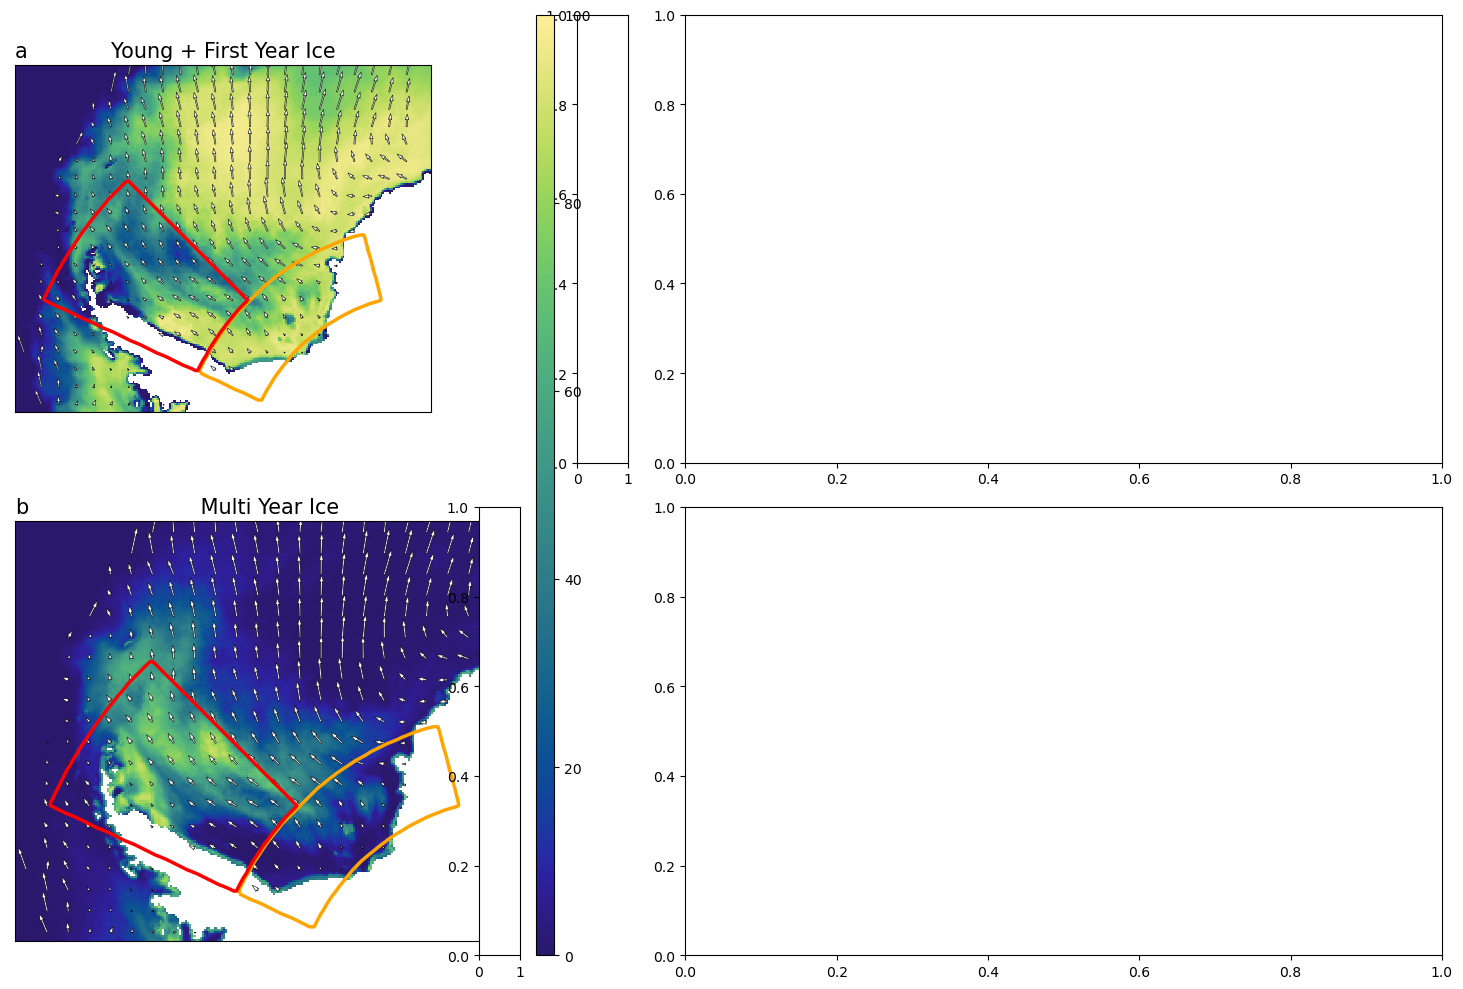

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=2, gridspec_kw={'width_ratios': [1, 0.1, 1.5]}, figsize=(15,10))
cmap = cmocean.cm.haline
box_colours = ['orange','r']
plt.tight_layout()  
fig.tight_layout()

ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)

a = YI_FYI.plot(cmap=cmap, ax=ax[0, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0,0], linewidth=2.5)
quiver = ax[0,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[0,0].set_title('a', fontsize=15, loc='left')
ax[0,0].set_title('Young + First Year Ice', fontsize=15, loc='center')

icetype_crop['MYI'].plot(cmap=cmap, ax=ax[1, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1,0], linewidth=2.5)
quiver = ax[1,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[1,0].set_title('b', fontsize=15, loc='left')
ax[1,0].set_title(' Multi Year Ice', fontsize=15, loc='center')

cbar = plt.colorbar(a,ax=[ax.ravel()[0],ax.ravel()[4]],aspect=50, pad=0.025)
# cbar = plt.colorbar(a,ax=[],aspect=50, pad=0.025)

# cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025,orientation='horizontal', )
# cbar.set_label(label="%", size=15,weight='bold')
# cbar.ax.tick_params(labelsize=15)

masked_SWSbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[0,2], color=colormap, legend=False)#.legend(loc='center left')
ATL20_masked_SWSbox_df.plot(ax=ax[0,2], secondary_y=True, color='red')

ax[0,1].right_ax.set_ylabel('Freeboard (m)').set_color('red')
# ax[0,1].set_ylabel('Concentration (%)')
ax[0,1].set_xlabel('')
ax[0,1].right_ax.set_ylim(0.15,0.6)
ax[0,1].right_ax.set_ylabel('Freeboard (m)').set_color('red')
ax[0,1].right_ax.tick_params(axis='y', colors='red')

area = masked_WWSnocbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[1,2], color=colormap, legend=False)#.legend(loc='lower left')
line = ATL20_masked_WWSnocbox_df.plot(ax=ax[1,2], secondary_y=True, color='red')

# ax[1,1].legend()
# ax[1,1].right_ax.set_ylabel('Freeboard (m)').set_color('red')
# ax[1,1].right_ax.tick_params(axis='y', colors='red')
# # ax[1,1].set_ylabel('Concentration (%)')
# ax[1,1].set_xlabel('')
# ax[1,1].right_ax.set_ylim(0.15,0.6)


# # plt.savefig('/g/data/jk72/sc0554/icemotion.png', dpi=300, bbox_inches='tight')
plt.show()

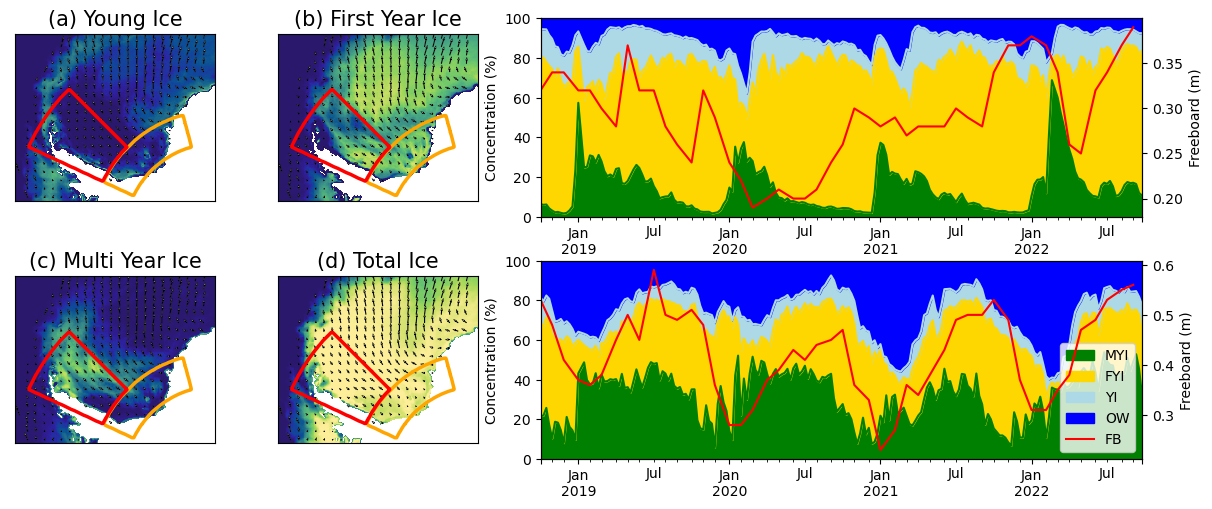

In [20]:
fig, ax = plt.subplots(ncols=3, nrows=2, gridspec_kw={'width_ratios': [1, 1, 3]}, figsize=(12,5))
cmap = cmocean.cm.haline
box_colours = ['orange','r']
plt.tight_layout()  
fig.tight_layout()

# [axi.xaxis.set_visible(False) for axi in ax.ravel()]
# [axi.yaxis.set_visible(False) for axi in ax.ravel()]

ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)

a = icetype_crop['YI'].plot(cmap=cmap, ax=ax[0, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0,0], linewidth=2.5)
quiver = ax[0,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[0,0].set_title('(a) Young Ice', fontsize=15)

icetype_crop['FYI'].plot(cmap=cmap, ax=ax[0, 1], vmin=0, vmax=100, add_colorbar=False,)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0,1], linewidth=2.5)
quiver = ax[0,1].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[0,1].set_title('(b) First Year Ice', fontsize=15)

icetype_crop['MYI'].plot(cmap=cmap, ax=ax[1, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1,0], linewidth=2.5)
quiver = ax[1,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[1,0].set_title('(c) Multi Year Ice', fontsize=15)

icetype_crop['TOTAL_ICE'].plot(cmap=cmap, ax=ax[1, 1], vmin=0, vmax=100,add_colorbar=False)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1,1], linewidth=2.5)
quiver = ax[1,1].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.4)
ax[1,1].set_title('(d) Total Ice', fontsize=15)

# cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025)
# cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025,orientation='horizontal', extend='max')
# cbar.set_label(label="%", size=15,weight='bold')
# cbar.ax.tick_params(labelsize=15)

masked_SWSbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[0,2], color=colormap, legend=False)#.legend(loc='center left')
ATL20_masked_SWSbox_df.plot(ax=ax[0,2], secondary_y=True, color='red')

ax[0,2].right_ax.set_ylabel('Freeboard (m)')
ax[0,2].set_ylabel('Concentration (%)')
ax[0,2].set_xlabel('')
area = masked_WWSnocbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[1,2], color=colormap, legend=False)#.legend(loc='lower left')
line = ATL20_masked_WWSnocbox_df.plot(ax=ax[1,2], secondary_y=True, color='red')

lines, labels = area.get_legend_handles_labels()
lines2, labels2 = line.get_legend_handles_labels()
ax[1,2].legend(lines + lines2, labels + ['FB'], loc='lower right')

ax[1,2].right_ax.set_ylabel('Freeboard (m)')
ax[1,2].set_ylabel('Concentration (%)')
ax[1,2].set_xlabel('')

# plt.savefig('/g/data/jk72/sc0554/icemotion.png', dpi=300, bbox_inches='tight')
plt.show()